In [132]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_013.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-22.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F10-43.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F66-12.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_193.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/10_00_063.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F5-2.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_133.p

# Importing Libraries

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

import plotly.graph_objs as go
from collections import Counter
from plotly.offline import iplot

import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model


import warnings
warnings.filterwarnings('ignore')

# Displaying images and masks

In [134]:
def display_images(data, no_img_mask):
    
    # Load the images from the files
    images = glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png')[:no_img_mask]
    masks = glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png')[:no_img_mask]

    for i in range(len(images)):
        images[i] = cv2.imread(images[i])
        masks[i] = cv2.imread(masks[i],cv2.IMREAD_GRAYSCALE) #to ensure it's loaded as a single-channel image.



    fig, axes = plt.subplots(no_img_mask, 2)

    for i in range(len(images)):
        axes[i][0].imshow(images[i])
        axes[i][1].imshow(masks[i])

    # Show the plot
    plt.show()

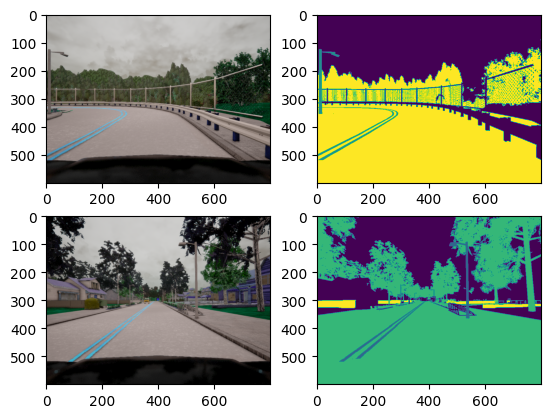

In [135]:
display_images('dataA', 2)

# Data Preparation

In [136]:
CameraRGB_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/" +"data"+ i+ "/CameraRGB/" for i in ["A","B","C","D","E"]]
CameraSeg_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/" +"data"+ i+ "/CameraSeg/" for i in ["A","B","C","D","E"]]
print(len(CameraRGB_path),len(CameraSeg_path))

5 5


In [137]:
def Having_ImagePaths_FromDirectory(directory_of_paths):
    ListOfImagePaths=[]
    for path in range(len(directory_of_paths)):
        NamesOfImages=os.listdir(directory_of_paths[path]) #to list all files in the current directory.
        for filename in NamesOfImages :
            ListOfImagePaths.append(directory_of_paths[path]+ filename)
    return ListOfImagePaths
Image_Paths=Having_ImagePaths_FromDirectory(CameraRGB_path)
Mask_Paths=Having_ImagePaths_FromDirectory(CameraSeg_path)
 #logic=5000
print(len(Image_Paths),len(Mask_Paths))

5000 5000


In [138]:
Image_Paths=Having_ImagePaths_FromDirectory(CameraRGB_path)
Mask_Paths=Having_ImagePaths_FromDirectory(CameraSeg_path)
number_of_images, number_of_masks = len(Image_Paths),len(Mask_Paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {Image_Paths[0]}")
print(f"3. An example of a mask path is: \n {Mask_Paths[0]}")

1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png
3. An example of a mask path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png


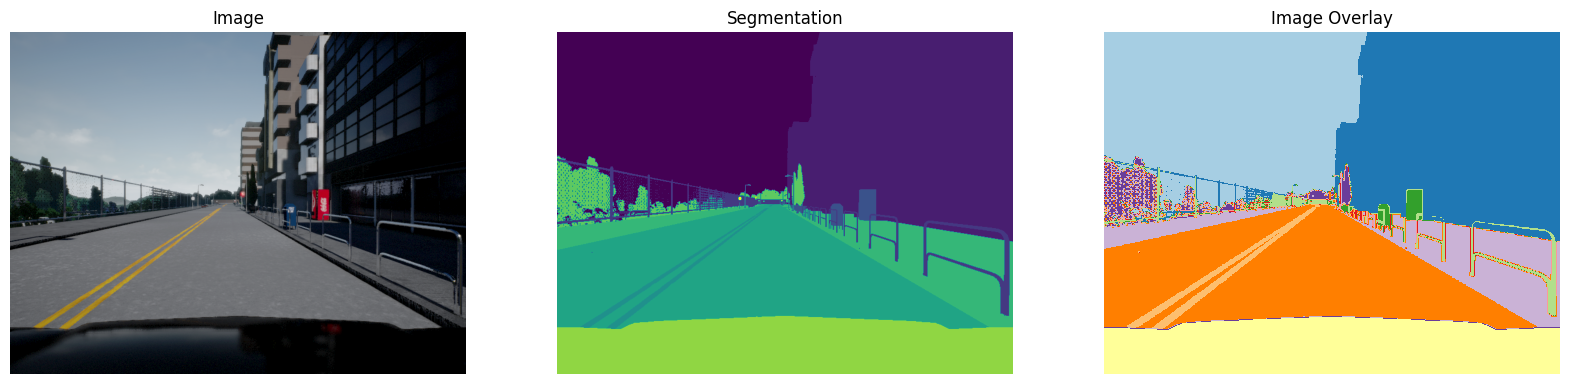

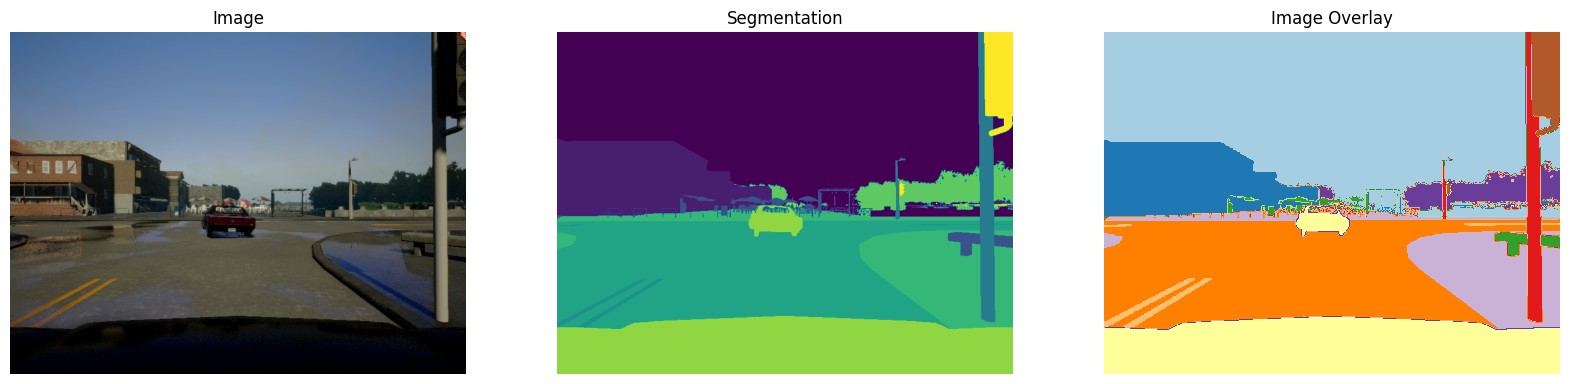

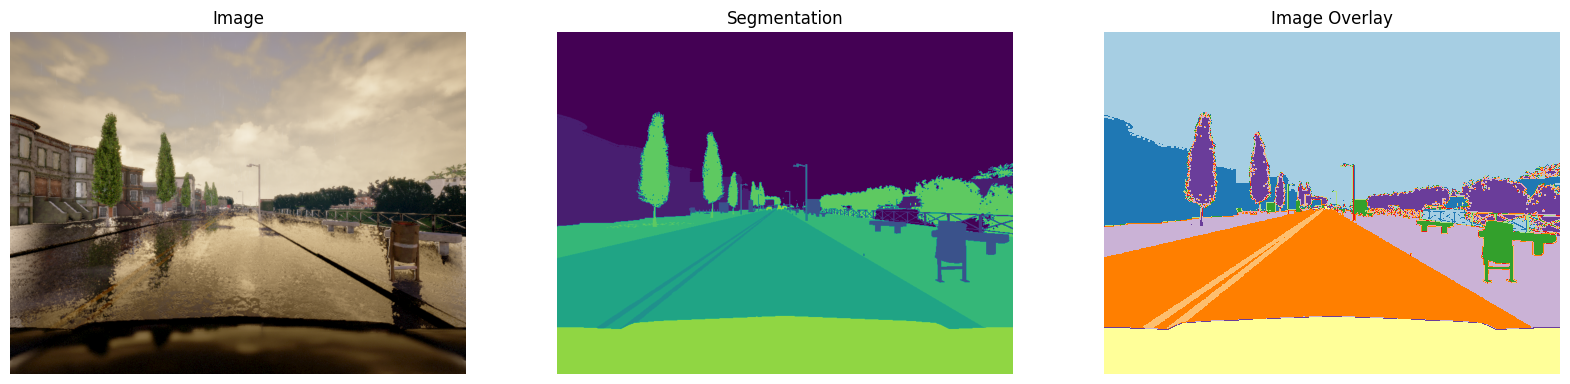

In [139]:
Nb_of_samples = len(Image_Paths)

for i in range(3):
    N = random.randint(0, Nb_of_samples - 1)

    img = imageio.imread(Image_Paths[N])
    mask = imageio.imread(Mask_Paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
    #converting the segmentation mask to a format suitable for visualization
    # the segmentation and overlay images appear black because the mask values are not correctly mapped to visible colors.
    #converting the mask values to a format compatible with visualization by taking the maximum value along each pixel location, 
    #ensuring it falls within the valid range for colormap mapping.
    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")  
    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

In [140]:
# First split the image paths into training and validation sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(Image_Paths, Mask_Paths, train_size=0.8, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(test_image_paths)} images in the Test Set')
print(f'There are {len(train_mask_paths)} masks in the Training Set')
print(f'There are {len(test_mask_paths)} masks in the Test Set')

There are 4000 images in the Training Set
There are 1000 images in the Test Set
There are 4000 masks in the Training Set
There are 1000 masks in the Test Set


# Data Preprocessing 

In [191]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask

In [192]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [193]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

In [194]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

# Label Distribution

In [195]:
def count_labels(dataset):
    # Counter for the labels
    label_counter = Counter()
    
    # Number of images
    n_images = 0

    # Iterate over the whole dataset
    for image, mask in dataset:
        # Count images
        n_images += 1

        # Get the label channel
        flat_mask = mask.numpy()[:, :, 0]  # Assuming mask is a single channel
        
        # Count the labels
        x = np.bincount(flat_mask.flatten())
        y = np.nonzero(x)[0]

        # Update the counter
        for key, val in zip(y, x[y]):
            label_counter[key] += val
            
    # Return counted labels and number of images
    return label_counter, n_images

In [234]:
CLASSES = {0:'Unlabeled',
           1:'Building',
           2:'Fence',
           3:'Other',
           4:'People',
           5:'Posts',
           6:'Road Marking',
           7:'Street',
           8:'Sidewalk',
           9:'Vegetation',
           10:'Vehicle',
           11:'Wall',
           12:'Traffic Sign'}

# RGB colors of the classes
COLORS = [(80/255, 168/255, 250/255),
          (242/255, 130/255, 30/255),
          (50/255, 50/255, 50/255),
          (27/255, 44/255, 129/255),
          (163/255, 68/255, 222/255),
          (115/255, 0/255, 0/255),
          (255/255, 255/255, 255/255),
          (191/255, 191/255, 191/255),
          (150/255, 150/255, 150/255),
          (22/255, 146/255, 0/255),
          (245/255, 239/255, 46/255),
          (181/255, 103/255, 10/255),
          (235/255, 0/255, 0/255)]

In [235]:
# Count labels in train and test datasets
train_label_counts, n_train_images = count_labels(train_dataset)
test_label_counts, n_test_images = count_labels(test_dataset)

# Convert label counts to dataframes
df_train_label_counts = pd.DataFrame.from_dict(train_label_counts, orient='index').rename({0:'Train'}, axis=1)
df_train_label_counts.index = [CLASSES[i] for i in df_train_label_counts.index]

df_test_label_counts = pd.DataFrame.from_dict(test_label_counts, orient='index').rename({0:'Test'}, axis=1)
df_test_label_counts.index = [CLASSES[i] for i in df_test_label_counts.index]

# Combine the label counts dataframes
df_label_counts = df_train_label_counts.join(df_test_label_counts)
df_label_counts = df_label_counts.stack().to_frame().reset_index().rename({'level_0':'Label', 'level_1':'Dataset', 0:'Count'}, axis=1)

In [239]:
import plotly.graph_objs as go


trace1 = go.Bar(y=df_tmp_train['Label'],
                x=df_tmp_train['Count'],
                base=0,
                name='Train',
                text=df_tmp_train['Count'],  # Set text to count values
                textposition='auto',
                hovertemplate='Pixel:  %{x}<br>Label: %{y}',
                width=0.55,
                marker=dict(color='#4CAF50'),  # Green color
                orientation='h',
                opacity=1.0,
                textfont=dict(size=40, color='black', family='Verdana'))  # Increase the size of the text and set color and family

trace2 = go.Bar(y=df_tmp_test['Label'],
                x=df_tmp_test['Count'],
                base=0,
                name='Test',
                text=df_tmp_test['Count'],  # Set text to count values
                textposition='auto',
                hovertemplate='Pixel:  %{x}<br>Label: %{y}',
                width=0.55,
                marker=dict(color='#FFC107'),  # Amber color
                orientation='h',
                opacity=1.0,
                textfont=dict(size=40, color='black', family='Verdana'))  # Increase the size of the text and set color and family

layout = dict(title='How Many Pixels Are There Per Label?',
              xaxis=dict(title='Count On Logscale',
                         type='log'),
              yaxis=dict(title='Label'),
              font=dict(family='sans-serif',
                        size=18,
                        color='#2f2f2f'),
              plot_bgcolor='#dddddd')

fig = go.Figure(data=[trace1, trace2], layout=layout)
iplot(fig)

# Data Augmentation

In [240]:
import tensorflow as tf

def read_image(image_path, mask_path, augment=False):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    if augment:
        # Random flip left-right
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)
        
        # Random flip up-down
        image = tf.image.random_flip_up_down(image)
        mask = tf.image.random_flip_up_down(mask)
    
    return image, mask

In [241]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size, augment=False):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    # Apply data augmentation if specified
    dataset = dataset.map(lambda x, y: read_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [242]:
train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size, augment=True)

In [243]:
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size, augment=False)

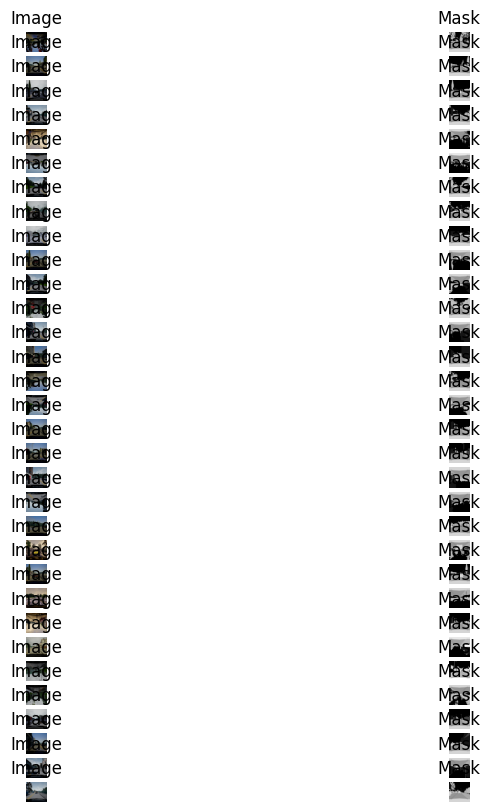

In [245]:
import matplotlib.pyplot as plt

# Function to plot images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(tf.squeeze(masks[i]), cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Extract a batch of images and masks from the train_dataset
batch_images, batch_masks = next(iter(train_dataset))

# Plot the images and masks
plot_images_and_masks(batch_images.numpy(), batch_masks.numpy())

In [246]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to apply data augmentation and plot images and masks
def plot_augmented_images(dataset, num_samples=8):
    # Initialize data augmentation layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    ])
    
    # Apply data augmentation to a subset of the dataset
    augmented_dataset = dataset.take(num_samples).map(lambda image, mask: (data_augmentation(image), data_augmentation(mask)))

    # Plot the augmented images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 20))
    for i, (image, mask) in enumerate(augmented_dataset):
        axes[i, 0].imshow(image.numpy())
        axes[i, 0].set_title('Augmented Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(tf.squeeze(mask.numpy()), cmap='gray')
        axes[i, 1].set_title('Augmented Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Plot augmented images and masks from the train_dataset
plot_augmented_images(train_dataset, num_samples=8)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'experimental'